In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 12.0]

In [3]:
import pandas as pd
import numpy as np

In [4]:
from pandas_summary import DataFrameSummary

In [5]:
# import my Finance Analysis Tools (fat)
import finance as fat

In [6]:
# full imports of fastai fail on windows, so just import some of it for now
from fastai.structured import add_datepart, apply_cats, proc_df

Don't run this on windows, only on paperspace...

In [7]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [8]:
PATH = 'data/gold-test'

## Load basic data

In [9]:
ticker = 'IAU'
data = fat.get_price_data(ticker)

Loaded data for IAU: 2005-01-28 to 2018-02-20.


In [10]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-13,12.74,12.77,12.70,12.76,12.76,8174100
2018-02-14,12.80,13.02,12.78,12.98,12.98,19514800
2018-02-15,13.01,13.02,12.95,12.99,12.99,13914600
2018-02-16,12.98,13.03,12.92,12.95,12.95,13618800
2018-02-20,12.88,12.90,12.75,12.77,12.77,13520800


## Create Features

We're going to try to be predicting tomorrow's closing price, so add it as a column.

In [11]:
data['Tomorrow Adj Close'] = data['Adj Close'].shift(-1)

In [12]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,Tomorrow Adj Close
Date,,,,,,,
2018-02-13,12.74,12.77,12.70,12.76,12.76,8174100,12.98
2018-02-14,12.80,13.02,12.78,12.98,12.98,19514800,12.99
2018-02-15,13.01,13.02,12.95,12.99,12.99,13914600,12.95
2018-02-16,12.98,13.03,12.92,12.95,12.95,13618800,12.77
2018-02-20,12.88,12.90,12.75,12.77,12.77,13520800,NaN


We'll also add google trends for searches for  "gold price usd"

In [13]:
search = "gold price usd"
trends = fat.get_google_trends_df(data, search)

In [14]:
trends.tail()

,gold price usd,Days since updated gold price usd
date,,
2018-01-28,88.0,27
2018-01-29,88.0,28
2018-01-30,88.0,29
2018-01-31,88.0,30
2018-02-01,75.0,0


In [15]:
#related_queries

In [16]:
data = pd.DataFrame.join(data, trends)

In [17]:
data = data.dropna()
data[-14:]

,Open,High,Low,Close,Adj Close,Volume,Tomorrow Adj Close,gold price usd,Days since updated gold price usd
Date,,,,,,,,,
2018-01-12,12.76,12.87,12.73,12.86,12.86,13305400,12.86,88.0,11.0
2018-01-16,12.82,12.87,12.79,12.86,12.86,7295900,12.77,88.0,15.0
2018-01-17,12.84,12.88,12.74,12.77,12.77,22220900,12.75,88.0,16.0
2018-01-18,12.79,12.80,12.73,12.75,12.75,18560300,12.78,88.0,17.0
2018-01-19,12.80,12.83,12.78,12.78,12.78,6918900,12.81,88.0,18.0
2018-01-22,12.81,12.83,12.78,12.81,12.81,6715900,12.88,88.0,21.0
2018-01-23,12.81,12.89,12.78,12.88,12.88,11162200,13.05,88.0,22.0
2018-01-24,13.00,13.08,12.98,13.05,13.05,15587600,12.94,88.0,23.0
2018-01-25,13.03,13.11,12.89,12.94,12.94,19944800,12.97,88.0,24.0


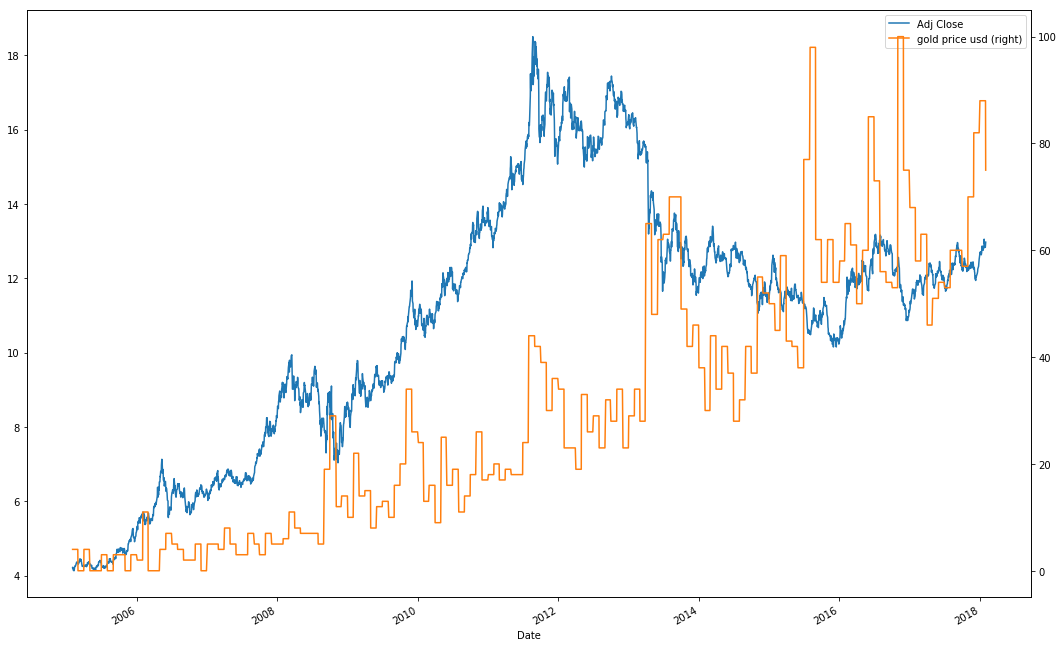

In [18]:
plot_data = data[['Adj Close', search]]
plot_data.plot(secondary_y = [search])

Add separate columns for various date parts.

In [19]:
data = data.reset_index()
add_datepart(data, 'Date', drop=False)
data = data.set_index('Date')

In [20]:
data.tail().T

Date,2018-01-26 00:00:00,2018-01-29 00:00:00,2018-01-30 00:00:00,2018-01-31 00:00:00,2018-02-01 00:00:00
Open,12.98,12.92,12.94,12.9,12.88
High,13.01,12.92,12.95,12.94,12.97
Low,12.95,12.84,12.83,12.79,12.86
Close,12.97,12.88,12.83,12.92,12.97
Adj Close,12.97,12.88,12.83,12.92,12.97
Volume,14350800,7974300,9532200,20848500,13352000
Tomorrow Adj Close,12.88,12.83,12.92,12.97,12.8
gold price usd,88,88,88,88,75
Days since updated gold price usd,25,28,29,30,0
Year,2018,2018,2018,2018,2018


Add in columns for several Simple Moving Averages for various periods of days.

In [21]:
sma_pct_diff = fat.get_sma_pct_diff_df(data, 'Adj Close')
del sma_pct_diff['Adj Close']
data = pd.DataFrame.join(data, sma_pct_diff)

In [22]:
data = data.dropna()

In [23]:
data.tail().T

Date,2018-01-26 00:00:00,2018-01-29 00:00:00,2018-01-30 00:00:00,2018-01-31 00:00:00,2018-02-01 00:00:00
Open,12.98,12.92,12.94,12.9,12.88
High,13.01,12.92,12.95,12.94,12.97
Low,12.95,12.84,12.83,12.79,12.86
Close,12.97,12.88,12.83,12.92,12.97
Adj Close,12.97,12.88,12.83,12.92,12.97
Volume,14350800,7974300,9532200,20848500,13352000
Tomorrow Adj Close,12.88,12.83,12.92,12.97,12.8
gold price usd,88,88,88,88,75
Days since updated gold price usd,25,28,29,30,0
Year,2018,2018,2018,2018,2018


In [24]:
DataFrameSummary(data).summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
Open,3075,11.2798,3.13554,4.663,9.001,11.78,12.9,18.51,3075,1606,0,0%,numeric
High,3075,11.3391,3.14613,4.68,9.0765,11.82,12.96,18.63,3075,1623,0,0%,numeric
Low,3075,11.2141,3.12339,4.651,8.9305,11.72,12.85,18.25,3075,1630,0,0%,numeric
Close,3075,11.2792,3.13566,4.664,9.013,11.78,12.895,18.5,3075,1631,0,0%,numeric
Adj Close,3075,11.2792,3.13566,4.664,9.013,11.78,12.895,18.5,3075,1631,0,0%,numeric
Volume,3075,4.96951e+06,4.588e+06,135000,2.11415e+06,3.8351e+06,6.35155e+06,6.99811e+07,3075,2904,0,0%,numeric
Tomorrow Adj Close,3075,11.2818,3.13351,4.664,9.015,11.78,12.895,18.5,3075,1630,0,0%,numeric
gold price usd,3075,31.8241,23.8356,0,11,28,51,100,3075,67,0,0%,numeric
Days since updated gold price usd,3075,14.7616,8.75017,0,7,15,22,30,3075,31,0,0%,numeric
Year,3075,2011.48,3.52928,2005,2008,2011,2015,2018,3075,14,0,0%,numeric


In [25]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Tomorrow Adj Close', 'gold price usd',
       'Days since updated gold price usd', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'pct diff Adj Close SMA3', 'pct diff Adj Close SMA5',
       'pct diff Adj Close SMA10', 'pct diff Adj Close SMA20',
       'pct diff Adj Close SMA50', 'pct diff Adj Close SMA100',
       'pct diff Adj Close SMA200'],
      dtype='object')

Break the columns up into "category variables" and "continuous variables".

In [26]:
cat_vars = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days since updated gold price usd',
            'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']

contin_vars = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'gold price usd', 'Elapsed',
               'pct diff Adj Close SMA3', 'pct diff Adj Close SMA5', 'pct diff Adj Close SMA10', 'pct diff Adj Close SMA20', 
               'pct diff Adj Close SMA50', 'pct diff Adj Close SMA100', 'pct diff Adj Close SMA200']

In [27]:
print(f'len(cat_vars) = {len(cat_vars)}')
print(f'len(contin_vars) = {len(contin_vars)}')
print(f'len(data.columns) = {len(data.columns)}')
assert(len(data.columns) == (len(cat_vars) + len(contin_vars) + 1))

len(cat_vars) = 13
len(contin_vars) = 15
len(data.columns) = 29


Split data into train and test sets.

In [28]:
data_len = len(data)
train_len = int(data_len * .8)
data_train = data[:train_len].copy()
data_test = data[train_len:].copy()

In [29]:
dep = 'Tomorrow Adj Close'
data_train = data_train.reset_index()
data_train = data_train[cat_vars+contin_vars+[dep, 'Date']].copy()

In [30]:
data_train.tail().T

,2455,2456,2457,2458,2459
Year,2015,2015,2015,2015,2015
Month,8,8,8,8,8
Week,34,34,34,34,35
Day,18,19,20,21,24
Dayofweek,1,2,3,4,0
Dayofyear,230,231,232,233,236
Days since updated gold price usd,17,18,19,20,23
Is_month_end,False,False,False,False,False
Is_month_start,False,False,False,False,False
Is_quarter_end,False,False,False,False,False


In [31]:
data_test[dep] = 0
data_test = data_test.reset_index()
data_test = data_test[cat_vars+contin_vars+[dep,'Date']].copy()

In [32]:
data_test.head().T

,0,1,2,3,4
Year,2015,2015,2015,2015,2015
Month,8,8,8,8,8
Week,35,35,35,35,36
Day,25,26,27,28,31
Dayofweek,1,2,3,4,0
Dayofyear,237,238,239,240,243
Days since updated gold price usd,24,25,26,27,30
Is_month_end,False,False,False,False,True
Is_month_start,False,False,False,False,False
Is_quarter_end,False,False,False,False,False


In [33]:
data_train = data_train.dropna()
data_test = data_test.dropna()

In [34]:
for v in cat_vars: 
    data_train[v] = data_train[v].astype('category').cat.as_ordered()

In [35]:
apply_cats(data_test, data_train)

In [36]:
for v in contin_vars:
    data_train[v] = data_train[v].astype('float32')
    data_test[v] = data_test[v].astype('float32')

In [42]:
DataFrameSummary(data_train).summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2460,11,0,0%,categorical
Month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2460,12,0,0%,categorical
Week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2460,53,0,0%,categorical
Day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2460,31,0,0%,categorical
Dayofweek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2460,5,0,0%,categorical
Dayofyear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2460,365,0,0%,categorical
Days since updated gold price usd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2460,31,0,0%,categorical
Is_month_end,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2460,2,0,0%,bool
Is_month_start,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2460,2,0,0%,bool
Is_quarter_end,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2460,2,0,0%,bool


We can now process our data...

In [50]:
# we get a AttributeError here if we don't have skip_flds = ['Date']
data_train = data_train.set_index('Date')
df_train, y, nas, mapper = proc_df(data_train, dep, do_scale=True)
yl = np.log(y)

In [51]:
df_train.head(2).T

Date,2005-11-14 00:00:00,2005-11-15 00:00:00
Year,1.000000,1.000000
Month,11.000000,11.000000
Week,46.000000,46.000000
Day,14.000000,15.000000
Dayofweek,1.000000,2.000000
Dayofyear,317.000000,318.000000
Days since updated gold price usd,14.000000,15.000000
Is_month_end,1.000000,1.000000
Is_month_start,1.000000,1.000000
Is_quarter_end,1.000000,1.000000


In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [52]:
train_ratio = 0.75
data_size = len(df_train)
train_size = int(data_size * train_ratio)
val_idx = list(range(train_size, data_size))

In [53]:
data_test = data_test.set_index('Date')
df_test, _, nas, mapper = proc_df(data_test, dep, do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [ ]:
#joined = joined.dropna()
#joined_test = joined_test.dropna()

## Deep Learning

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [54]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

We can create a ModelData object directly from out data frame.

In [55]:
# before: bs=128, changed to bs=8 to get results while finding learning rate
md = ColumnarModelData.from_data_frame(PATH, val_idx, df_train, yl.astype(np.float32), cat_flds=cat_vars, bs=8,
                                       test_df=df_test)

Create categorical variables.

In [56]:
cat_sz = [(c, len(data_train[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('Year', 12),
 ('Month', 13),
 ('Week', 54),
 ('Day', 32),
 ('Dayofweek', 6),
 ('Dayofyear', 366),
 ('Days since updated gold price usd', 32),
 ('Is_month_end', 3),
 ('Is_month_start', 3),
 ('Is_quarter_end', 3),
 ('Is_quarter_start', 3),
 ('Is_year_end', 3),
 ('Is_year_start', 2)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [57]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(12, 6),
 (13, 7),
 (54, 27),
 (32, 16),
 (6, 3),
 (366, 50),
 (32, 16),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (2, 1)]

Find learning rate.

In [58]:
m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [59]:
m.lr_find(1e-7,1e-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.057756   0.080914  



In [ ]:
m.sched.plot_lr()

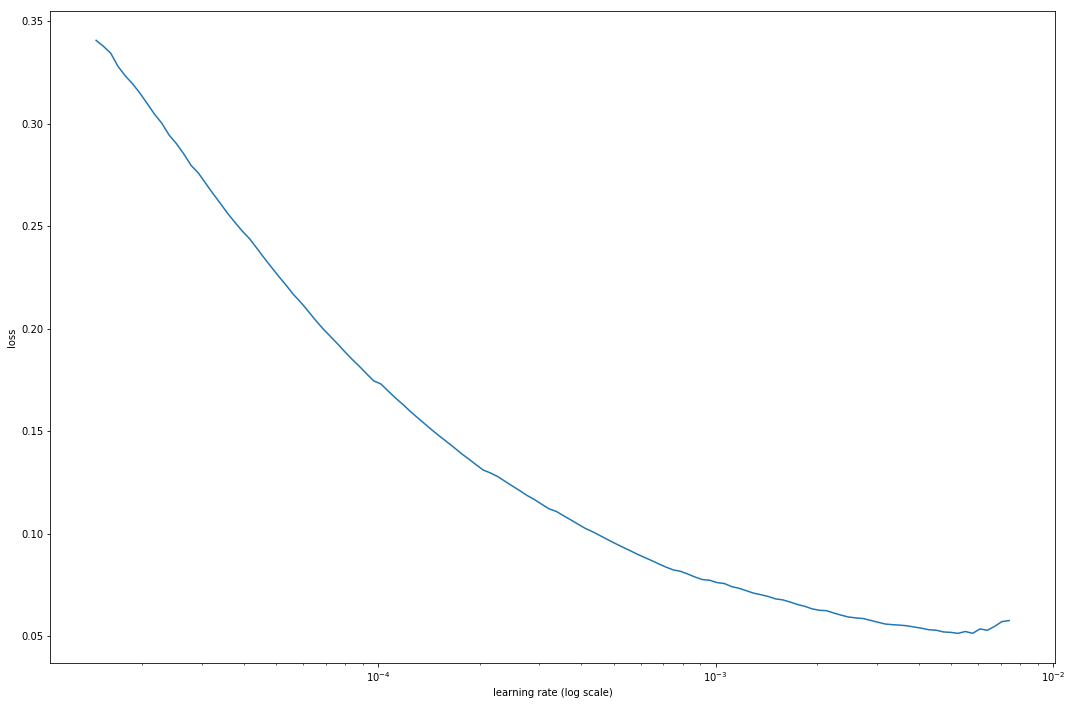

In [60]:
m.sched.plot(100)

### Sample

In [61]:
m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [62]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.00796    0.00942    0.08614   
    1      0.005329   0.003728   0.055165                       
    2      0.001971   0.006339   0.071951                       



[0.006339245, 0.071950764944373]

In [63]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.001713   0.003978   0.056623  
    1      0.001201   0.001724   0.037296                       
    2      0.001008   0.001378   0.032992                       
    3      0.000807   0.001406   0.033918                        
    4      0.000829   0.001582   0.034456                        



[0.0015822729, 0.03445642500384379]

In [64]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.001594   0.003546   0.054985  
    1      0.000919   0.001375   0.033083                        
    2      0.000459   0.001615   0.035891                        
    3      0.000407   0.001297   0.030758                        
    4      0.001031   0.001098   0.029496                       
    5      0.000817   0.001375   0.032546                        
    6      0.000383   0.000924   0.026688                        
    7      0.000337   0.000988   0.027534                        



[0.0009876213, 0.027533556053978624]

In [ ]:
m.save('val0')

In [ ]:
m.load('val0')

In [65]:
x,y=m.predict_with_targs()

In [66]:
exp_rmspe(x,y)

0.03046785977634194

In [67]:
pred_test=m.predict(is_test=True)

In [68]:
pred_test = np.exp(pred_test)

In [69]:
data_test[dep]=pred_test

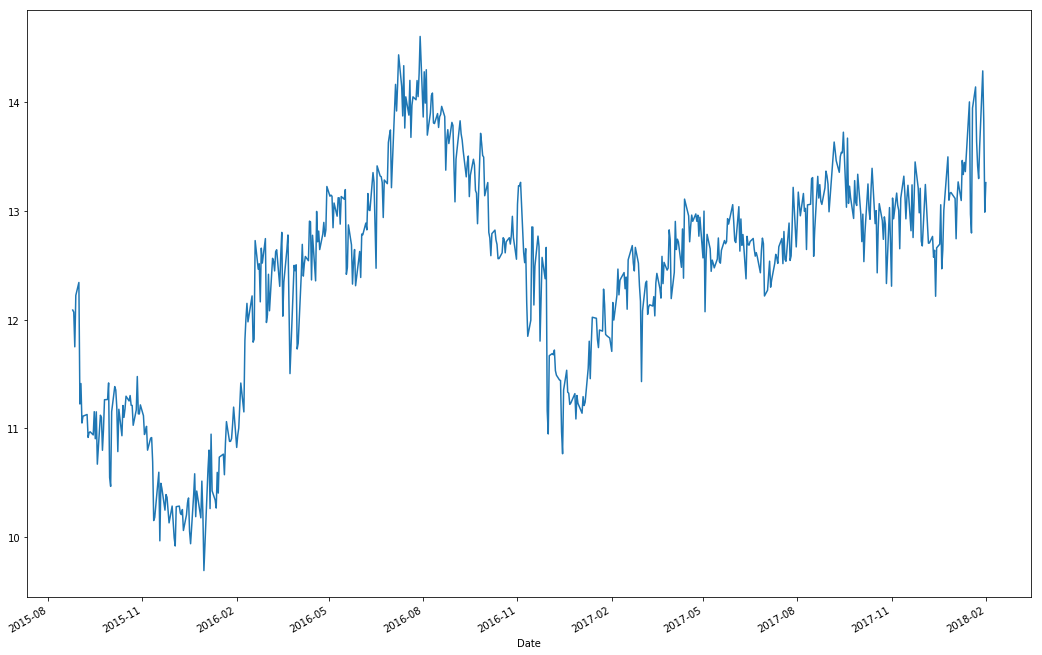

In [71]:
data_test[dep].plot()

In [74]:
csv_fn=f'{PATH}/sub.csv'

In [78]:
data_test[dep].to_csv(csv_fn)